In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def img_show(img : np.ndarray, cmap = 'gray', vmin = 0, vmax = 255, interpolation = 'none') -> None:
    '''np.arrayを引数とし、画像を表示する。'''

    #dtypeをuint8にする
    #オーバーフロー、アンダーフローの処理

    img = np.clip(img,vmin,vmax).astype(np.uint8)

    #画像を表示
    plt.imshow(img, cmap = cmap, vmin = vmin, vmax = vmax, interpolation = interpolation)
    plt.show()
    plt.close()

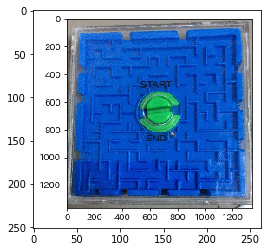

In [12]:
#画像の読み込み
#imgに三次元のnp.arrayの配列が格納される。
img = plt.imread('labyrinth.png') 
type(img) #=> numpy.ndarray
img.size #=> (1367, 1345, 3)


#画像の表示
plt.imshow(img) 
plt.show() #使った画像が小さいときはボケて見えるけど今は気にしないで

#画像の保存
plt.imsave('labyrinth-1.png', img) #拡張子を.pngとかに変えてもちゃんと保存してくれる。

In [13]:
def decomposition(img : np.ndarray, channel : list = [1.,1.,1.]) -> np.ndarray:
    '''channelに与えられた強度でチャンネルごとに強調する'''

    float_img = img * channel
    return np.array(float_img,dtype = np.uint8)

img = plt.imread('labyrinth.png')
img_show(decomposition(img, [1.,0.,0.]), cmap = 'Reds')
img_show(decomposition(img, [0.,1.,0.]), cmap = 'Greens')
img_show(decomposition(img, [0.,0.,1.]), cmap = 'Blues')

ValueError: operands could not be broadcast together with shapes (251,263,4) (3,) 

In [14]:
def convolve2d(img, kernel):
    #部分行列の大きさを計算
    sub_shape = tuple(np.subtract(img.shape, kernel.shape) + 1)

    #関数名が長いのでいったん省略
    strd = np.lib.stride_tricks.as_strided

    #部分行列の行列を作成
    submatrices = strd(img,kernel.shape + sub_shape,img.strides * 2)

    #部分行列とカーネルのアインシュタイン和を計算
    convolved_matrix = np.einsum('ij,ijkl->kl', kernel, submatrices)

    return convolved_matrix

In [84]:
#フィルターのカーネルの作成
gaussian = np.array([[21,31,21],
                     [31, 48,31],
                     [21,31,21]])/256
laplacian = np.array([[ 0,-1, 0],
                      [-1, 4,-1],
                      [ 0,-1, 0]]) 

#画像の読み込み
img = plt.imread('labyrinth.png')
img = img[...,1] # 今回はGチャンネルのみを対象とする。

#ガウスぼかしを20回かける
for _ in range(10):
    img = convolve2d(img, gaussian)

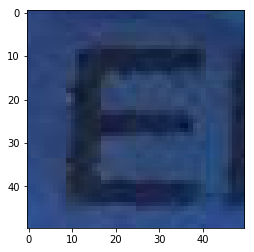

In [87]:
img = plt.imread('tiger.jpg')[1390:1440,375:425]
img_show(img)

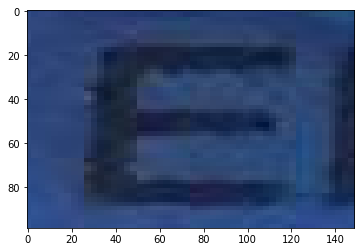

In [104]:
#参照する座標が四捨五入で計算されるため、100,450にするとインデックスエラーになる
height, width = 99, 149

x,y = np.mgrid[:height,:width]
xy_after = np.dstack((x,y,np.ones((height, width))))

#アフィン変換の行列を用意
#縦に2倍、横に3倍
affin = np.matrix('2,0,0;0,3,0;0,0,1')
inv_affin = np.linalg.inv(affin)

#参照する座標を計算
ref_xy = np.einsum('ijk,lk->ijl',xy_after,inv_affin)[...,:2]
ref_nearmost_xy = (ref_xy + 0.5).astype(int)
img_nearmost = img[ref_nearmost_xy[...,0],ref_nearmost_xy[...,1]]

img_show(img_nearmost)

In [105]:
def clip_xy(ref_xy, img_shape):
    #x座標について置換
    ref_x = np.where((0<=ref_xy[...,0])&(ref_xy[...,0]<img_shape[0]),ref_xy[...,0],-1)
    #y座標について置換
    ref_y = np.where((0<=ref_xy[...,1])&(ref_xy[...,1]<img_shape[1]),ref_xy[...,1],-1)

    #結合して返す
    return np.dstack([ref_x,ref_y])

In [107]:
#背景色を設定
bg_color = [0,0,0]

#背景色で埋められた一回り大きい画像を作成
img_bg = np.empty(np.add(img.shape,(1,1,0)))
img_bg[:,:] = bg_color

#画像を貼り付ける
img_bg[:-1,:-1] = img


#高さ150・幅500の変換後画像を作成
height, width = 150, 500
x,y = np.mgrid[:height,:width]
xy_after = np.dstack((x,y,np.ones((height, width))))
#アフィン変換の行列を用意
#縦に2倍、横に3倍
affin = np.matrix('2,0,0;0,3,0;0,0,1')
inv_affin = np.linalg.inv(affin)

#最近傍法で画像を変換
ref_xy = np.einsum('ijk,lk->ijl',xy_after,inv_affin)[...,:2]
ref_nearmost_xy = (ref_xy + 0.5).astype(int)
ref_nearmost_xy = clip_xy(ref_nearmost_xy,img_bg)
#clip_xyで参照するピクセルが最終行、最終列を参照するように変更
img_nearmost_bg = img_bg[ref_nearmost_xy[...,0],ref_nearmost_xy[...,1]]
img_show(img_nearmost_bg)

ValueError: operands could not be broadcast together with shapes (150,500) (51,3) 